In [1]:
from pricing import DiscountingCurve, Black, EquityForwardCurve, Call_Closed
import numpy as np
import matplotlib.pyplot as plt
from montecarlo import Monte_Carlo_Analisys

In [2]:
d = DiscountingCurve(reference=0,zero_rate=0.01)
f = EquityForwardCurve(spot = 100, reference=0,discounting_curve=d,repo_rates=0,dividend_yelds=0)
b = Black(volatility=0.2,forward_curve=f)

In [3]:
date = np.linspace(0.001,1,100)
S_t = b.simulate(fixings=date,Nsim=1e6)

In [4]:
payoff = b.Call_PayOff(S_t,100)*d(date)

In [5]:
x,mean,err = Monte_Carlo_Analisys(payoff,100)

In [6]:
real = Call_Closed(100,100,date,0.01,0,0.2)

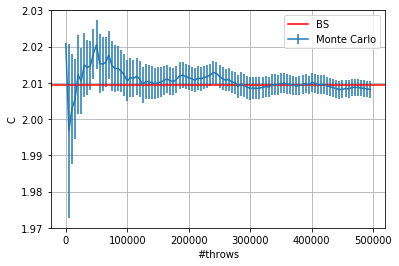

In [7]:
n = 6
plt.axhline(y=real[n], color = 'red',linestyle='-',label = 'BS')
plt.errorbar(x,mean.T[n],yerr=err.T[n],label = 'Monte Carlo')
plt.xlabel('#throws')
plt.ylabel('C')
plt.grid(True)
plt.legend()
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


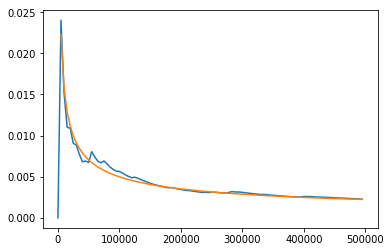

In [8]:
plt.plot(x,err.T[n])
plt.plot(x,np.std(payoff.T[n])/np.sqrt(x))

In [9]:
print("errore: ",err.T[n][len(err.T)-1])

errore:  0.002275524727114425


In [10]:
print("errore: ",err.T[n][len(err.T)-1])

errore:  0.0030814313058422672
